**Principles and Practice of Remote Sensing**

**Practical:  Feature tracking**


The aims of this practical are:

1.	To introduce concepts and applications related to feature tracking in EO imagery.
2.	To explore various algorithms and parameters related to tracking features in EO imagery.
3.	To produce feature tracking results in test cases.

This practical will be run through a Jupyter notebook: all the files and data you need are already incldued in this file. If you haven't come across notebooks before, you can read more about them here: https://jupyter.org/.

To briefly cover the basics, there are three types of cells:
* Text (like this cell)
* Code (python code, which you will need to run)
* Code outputs (which will appear once you run the code)

First, we need to import some packages which we will use throughout this practical. You will need to run the cell below, but it will not generate any output (it will however load the packages into python).

In [154]:
# <- note, the hashtag indicates that this is a comment, and will not be run as part of the code. Use this to describe
# what you are doing in the code

#Written by Max Van Wyk de Vries (2021), based on a MATLAB practical prepared by N. Gourmelen; J. Williams (2017), updated by Josh Williams (2018) and Peter Green (2019)

#Import necessary packages
!mamba install -yq -c conda-forge autorift --strict-channel-priority
import pandas as pd
import numpy as np
import cv2
import scipy 
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
import scipy.signal as signal
import pdb
from osgeo import gdal, osr
from autoRIFT import autoRIFT

plt.rcParams['figure.figsize'] = [14, 14] #Set default plot size a little larger

**Introduction: Measures of similarity**

In this exercise, we are going to manually investigate the difference between two signals. We are going to start off doing this in one dimensions in order to understand the underlying method.

We have created two box functions, which are identical except for a certain offset. Your job here is to identify this offset by manually estimating the offset value. 

Start with an offset value of zero, and observe the position of the two curves. Then, continue entering new values (enter 'y' to the next prompt) to improve the fit.

For each offset value you enter, the code will output the *correlation coefficient* between the two curves. For an offset of zero this will be negative (the high values of the red curve coincide with the low values of the red curve, on average). As you improve the fit, this will become positive. For a perfect fit, the correlation coefficient will be 1. 

*Questions*

*Q1: What value of offset is needed here in order to achieve a correlation coefficient of 1?*

*Q2: Why do you think the code fails (produces an error) when you enter a non-integer offset?*

Enter an offset12


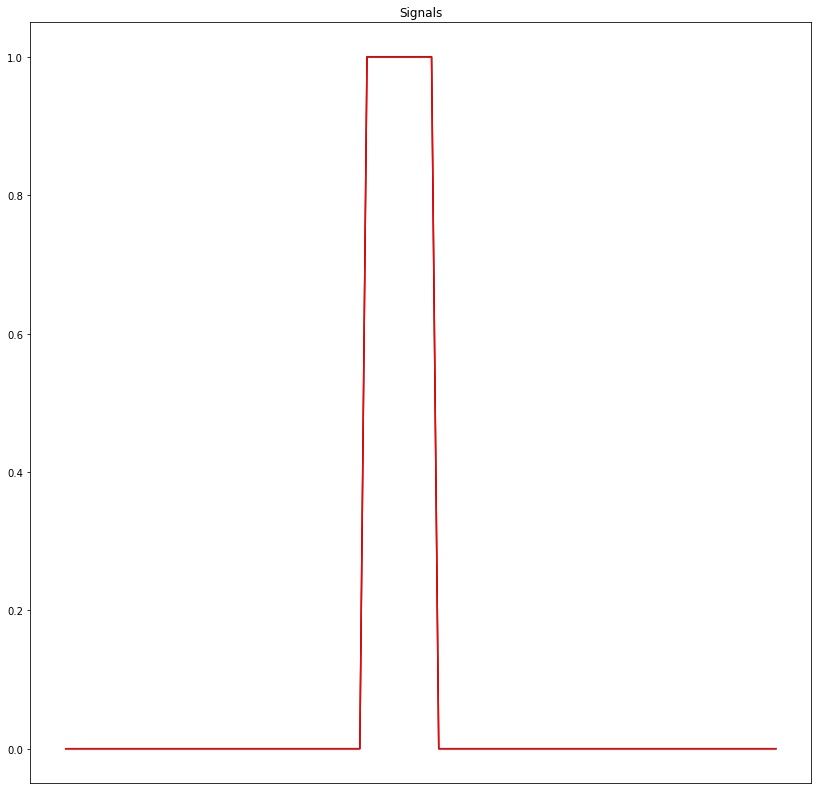

The product of the signals is 10.0
The correlation coefficient between the signals is 1.0
Congratulations, you found the ideal offset!


In [3]:
# You do not need to read this code. Just press run
continue_flag = 'y'

while continue_flag != 'n':
    offset = int(input('Enter an offset'))
    #Create the signals, each 100 units long
    b = np.zeros(100);a = np.zeros(100);a[30+offset:40+offset]=1; b[42:52]=1;
    c=a@b
    d= np.sum((a-np.mean(a))*(b-np.mean(b)))/np.sum(((a-np.mean(a))**2*(b-np.mean(b))**2)**0.5); #np.correlate(a,b)/10
#     plt.subplot(121)
    plt.plot(a,'k');plt.plot(b,'r');ax = plt.gca();ax.axes.xaxis.set_visible(False);plt.title('Signals');plt.show();
    print('The product of the signals is ' +str(c))
    print('The correlation coefficient between the signals is ' +str(d))
    if c!= 10:
        continue_flag = input('Do you want to continue entering additional offsets? y/n')
    else:
        print('Congratulations, you found the ideal offset!')
        continue_flag = 'n'

Real signals do not look like these box functions. The signals we deal with in the geosciences tend to be noisy - a certain amount of noise is inevitably in the data.

Repeat the previous excercise, except this time with some (pure randon) noise introduced into the box functions.

Note, you will need to answer 'n' to the second prompt to end this run.

*Questions*

*Q3: Can you achieve a correlation coefficient of 1?*

*Q4: What value of offset is needed here in order to maximize your correlation coefficient?*

*Q5: Are you as confident about having achived the correct match as the previous example?*

Enter an offset10


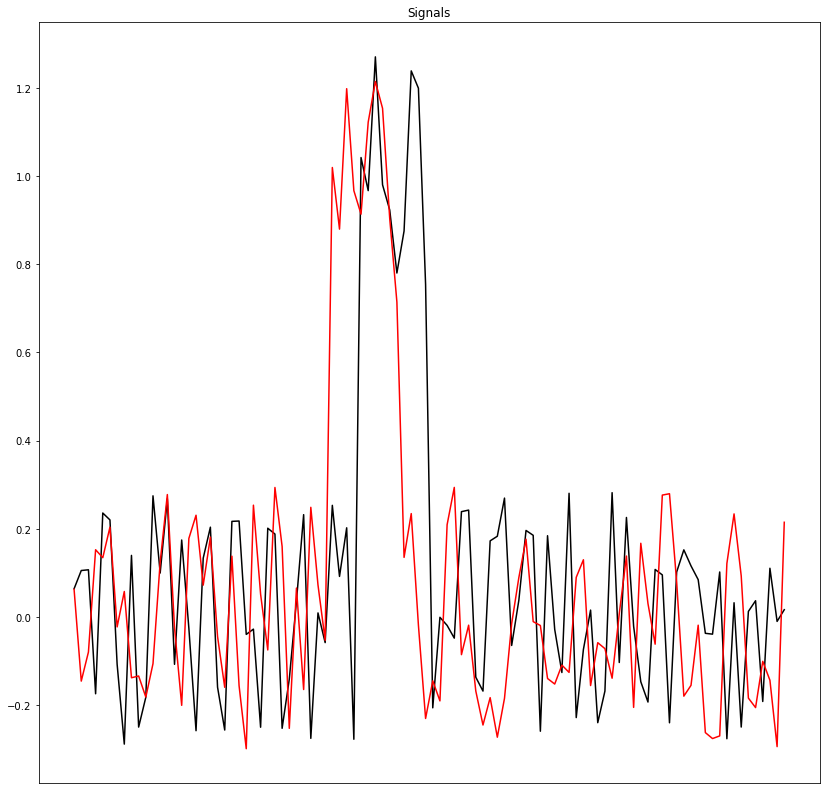

The product of the signals is 6.401113135816851
The correlation coefficient between the signals is 0.6576047560286761
Do you want to continue entering additional offsets? y/nn


In [146]:
# You do not need to read this code. Just press run
continue_flag = 'y'

while continue_flag != 'n':
    offset = int(input('Enter an offset'))
    #Create the signals, each 100 units long
    b = -0.3+0.6*np.random.rand(100);a = -0.3+0.6*np.random.rand(100); a[30+offset:40+offset]+=1; b[36:46]+=1;
    c=a@b
    d= np.sum((a-np.mean(a))*(b-np.mean(b)))/np.sum(((a-np.mean(a))**2*(b-np.mean(b))**2)**0.5); #np.correlate(a,b)/10
#     plt.subplot(121)
    plt.plot(a,'k');plt.plot(b,'r');ax = plt.gca();ax.axes.xaxis.set_visible(False);plt.title('Signals');plt.show();
    print('The product of the signals is ' +str(c))
    print('The correlation coefficient between the signals is ' +str(d))
    continue_flag = input('Do you want to continue entering additional offsets? y/n')


Now let's do the same thing one last time, but with an even larger amount of noise.

*Questions*

*Q6: What is the highest correlation coefficient you can achieve? How does it compare to the previous examples?*

*Q7: How confident are you in having found the correct offset? Why?*

Enter an offset10


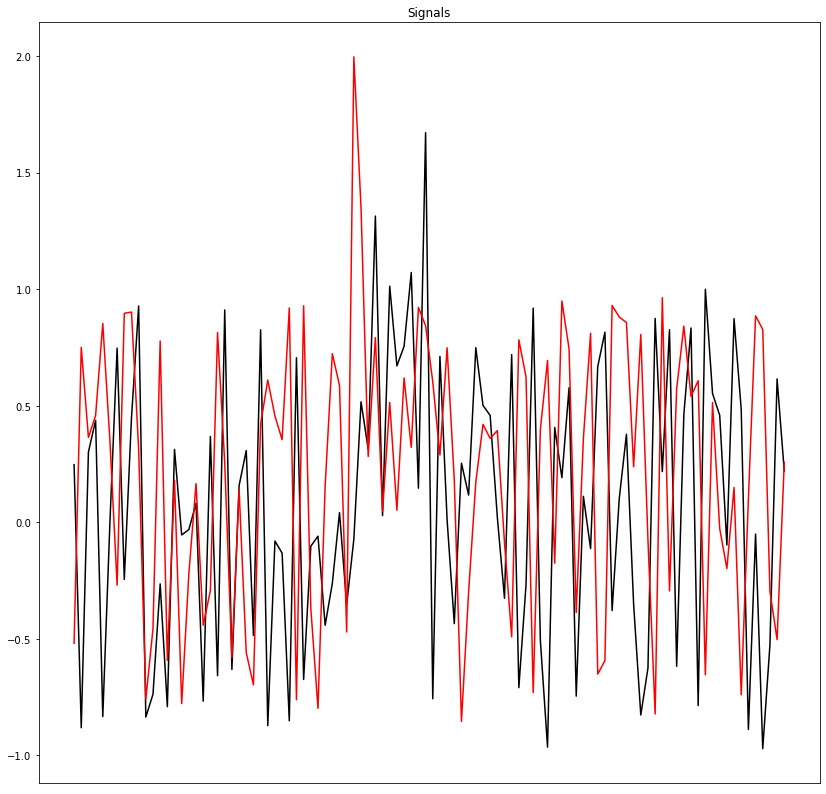

The product of the signals is -2.5159864490464128
The correlation coefficient between the signals is -0.15908057969328424
Do you want to continue entering additional offsets? y/nn


In [147]:
# You do not need to read this code. Just press run
continue_flag = 'y'

while continue_flag != 'n':
    offset = int(input('Enter an offset'))
    #Create the signals, each 100 units long
    b = -1+2*np.random.rand(100);a = -1+2*np.random.rand(100); a[30+offset:40+offset]+=1; b[39:49]+=1;
    c=a@b
    d= np.sum((a-np.mean(a))*(b-np.mean(b)))/np.sum(((a-np.mean(a))**2*(b-np.mean(b))**2)**0.5); #np.correlate(a,b)/10
#     plt.subplot(121)
    plt.plot(a,'k');plt.plot(b,'r');ax = plt.gca();ax.axes.xaxis.set_visible(False);plt.title('Signals');plt.show();
    print('The product of the signals is ' +str(c))
    print('The correlation coefficient between the signals is ' +str(d))
    continue_flag = input('Do you want to continue entering additional offsets? y/n')

Not only is finding the correct match manually rather tedious, it becomes almost impossible for noisy data. This is why we get the computer to do it automatically for us. This automated comparison of two signals is the basis for most feature tracking methods.

In order to examine how this works, let's look back at our 'perfect' box functions using an offset of 10:

Note there is a noise option. Ignore it for now, but you will want to come back an edit it in a little while.

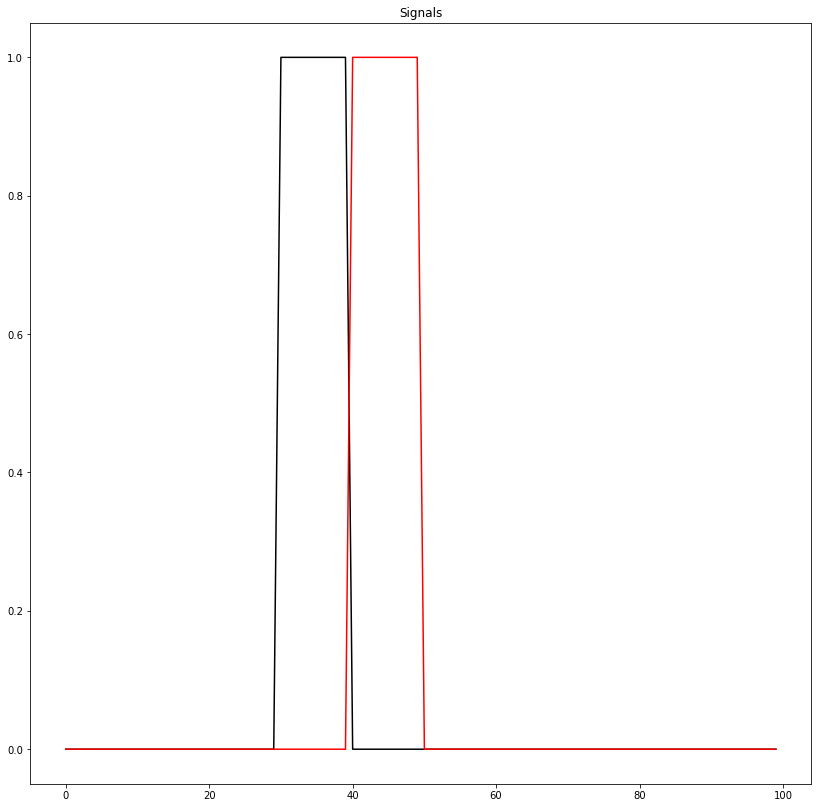

In [148]:
offset = 10
noise = 0

############## Edit the options above this line

if noise == 0:
    b = np.zeros(100);a = np.zeros(100);a[30:40]=1; b[30+offset:40+offset]=1;
else:
    b = -(noise*0.5)+noise*np.random.rand(100);a = -(noise*0.5)+noise*np.random.rand(100);a[30:40]+=1; b[30+offset:40+offset]+=1;    
        
plt.plot(a,'k');plt.plot(b,'r');plt.title('Signals');plt.show();

Now, say we want to identify a small portion of the black curve in the red curve. Let's crop out a portion of this black curve between 20 and 40:

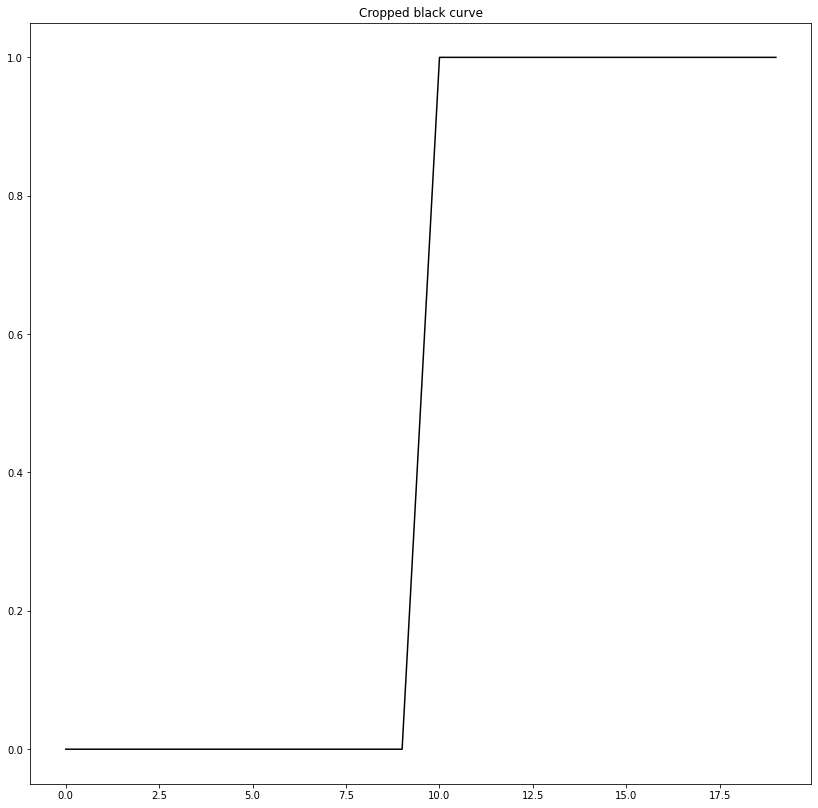

In [149]:
a_crop = a[20:40]
plt.plot(a_crop,'k');plt.title('Cropped black curve');plt.show();

Now, let's calculate the correlation coefficient between this 'cropped out' portion of the black curve and all of the red curve. If everything works out, we should get the highest correlation coefficient when this matches the same portion of the red curve.

*Q8: A warning appears when you run this. Do you have any idea why? (hint: look up the equation for the correlation coefficient, and think about what would happen when one of the series being correlated is all zero)*

<ipython-input-150-7b6f93ccb5fe>:3: RuntimeWarning: invalid value encountered in double_scalars
  correlation_coefficient[loop] = np.sum((a_crop-np.mean(a))*(b[loop:loop+20]-np.mean(b[loop:loop+20])))/np.sum(


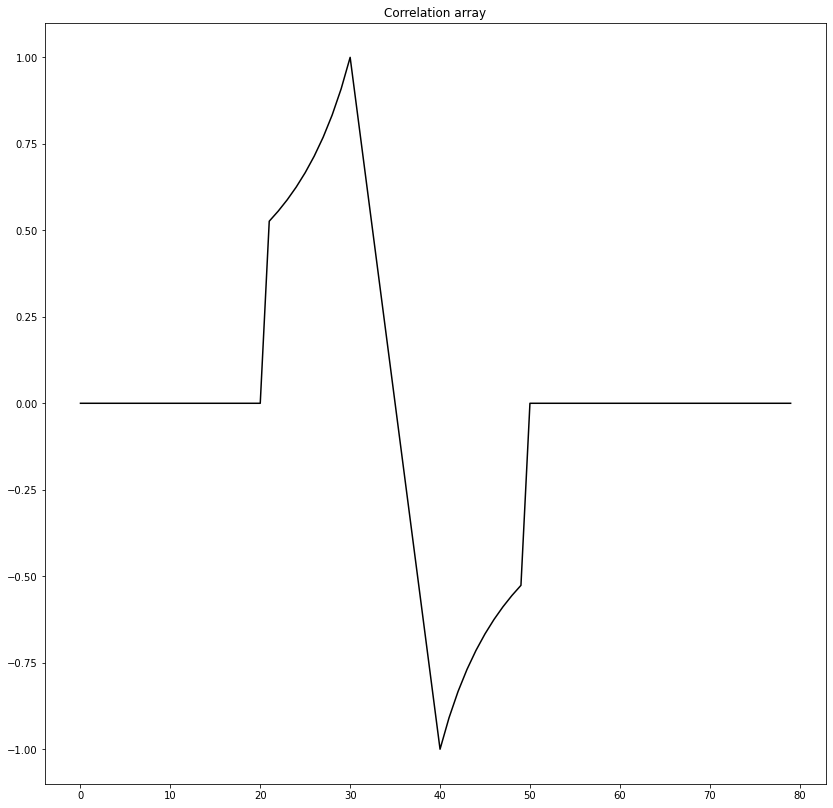

In [150]:
correlation_coefficient = np.zeros(80)
for loop in range(80):
    correlation_coefficient[loop] = np.sum((a_crop-np.mean(a))*(b[loop:loop+20]-np.mean(b[loop:loop+20])))/np.sum(
        ((a_crop-np.mean(a_crop))**2*(b[loop:loop+20]-np.mean(b[loop:loop+20]))**2)**0.5);

correlation_coefficient[np.isnan(correlation_coefficient)] = 0

plt.plot(correlation_coefficient,'k');plt.title('Correlation array');plt.show();

We have now created an array of correlation coefficients. These represent how good the fit between the two cropped out pieces of curve is. This reaches 1 at one point, or a perfect fit! 

We just need one final step now: compare the position of the original cropped-out black curve (20) to the position of maximum correlation coefficient.

In [151]:
position_correlation = np.argmax(correlation_coefficient)
offset_calculated=position_correlation-20;

print('The calculated offset was ' + str(offset_calculated)+ ' pixels, compared to the real offset of ' + str(offset) +' pixels.')
print('The error is ' + str(abs(offset_calculated-offset)) + ' pixel(s).')

The calculated offset was 10 pixels, compared to the real offset of 10 pixels.
The error is 0 pixel(s).


They match - the computer did the same job you did much more efficiently. We can easily upscale this method into two dimensions, comparing the patterns between two images istead of the pattern in a single curve. There are a couple of questions below asking you to explore the effect of noise levels a little more. We will then move onto some real-life examples.

*Q9: Scroll back up the notebook and edit the parameter named 'noise' in the code above. Rerun the code down to this one, and explore the effect of different noise levels.*

*Can the computer correctly estimate the displacement even with some noise in the data?*
*Can the computer correctly estimate the displacement even when the noise level is too high for you to do it by eye?*
*At what noise level is the computer no longer able to identify any patterns?*

Keep these issues of noise in mind when using this method for real world applications.

**Main: Tracking movement in videos**


We are now done going to explore motion in two dimensions using images (or video frames). Depending on the type of motion, noise levels in the original image, and required precision we may use different methods to calculate motion.

These may be broadly grouped into two categories:
* Optical flow based methods, which calculates the pattern of apparent motion by solving a function at specific locations in an image. (If you want to read about the mathematical background, here is a good place to start: http://www.cs.toronto.edu/~fleet/research/Papers/flowChapter05.pdf)
* Feature tracking based methods (also known as 'template matching' or 'particle image velocimetry') which cross-correlate two-dimensional subsets of images to identify the location of features through time. Have a look at Heid and Kaab (2012: http://dx.doi.org/10.1016/j.rse.2011.11.024) or Van Wyk de Vries and Wickert 2021 (https://tc.copernicus.org/articles/15/2115/2021/tc-15-2115-2021.html) and references for more details.

In general, optical flow based methods are best adapted to situations in which a continuous timeseries of images is available with small displacements between images (for instance with a video). For example, self-driving cars can use optical flow in combination with LiDAR to track obstacles. Optical flow algorithms are generally quite efficient, and can be applied to video in real time.

Feature tracking is adapted to problems in which displacements are large (on the order of several pixels) or the images used to track motion contain a lot of 'noise'. Real satellite images are often 'noisy' due to changes in the earth's surface, cloud cover, or shadowing. Feature tracking is often used in the earth sciences to track glacier flow or coseismic displacement.

We will explore three examples here:
1. Extracting motion from video frames
2. Measuring the flow of Perito Moreno Glacier (Patagonia) using Sentinel-2 satellite imagery
3. Calculating displacement and seismic moment of the 2016 Kaikura Earthquake (New Zealand)

First, we need to define a few functions. Just run the cell below, we will use these functions in the following sections.

In [152]:
# No need to read this, but feel free to try and work out what these do


##############################################################
#Gunnar-Farneback optical flow - based on the OPENCV implementation
def GFopticalFlow(image1, image2, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma):
    
    flow = cv2.calcOpticalFlowFarneback(image1,
                                        image2,
                                        flow,
                                        pyr_scale,
                                        levels,
                                        winsize,
                                        iterations,
                                        poly_n,
                                        poly_sigma,
                                        0)
    
    u = flow[...,0]; v = flow[...,1]

    #Convert x and y components of displacement to direction and magnitude
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    return(mag,ang,u,v)

##############################################################
#Plotting script (based on MATPLOTLIB)
def fourPlot(mag,ang,u,v):
    #find min and max of  u and v
    maxu = np.nanmax(np.abs(u));maxv = np.nanmax(np.abs(v));
    plt.subplot(2,2,1)
    plt.imshow(mag);plt.title('Magnitude of displacement (pixels)');plt.colorbar()
    plt.subplot(2,2,2)
    plt.imshow(ang*180/3.1415,cmap='twilight');plt.title('Angle of displacement (pixels)');plt.colorbar()
    plt.subplot(2,2,3)
    plt.imshow(u,cmap='seismic',vmax=maxu,vmin=-maxu);plt.title('X displacement (pixels)');plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(v,cmap='seismic',vmax=maxv,vmin=-maxv);plt.title('Y displacement (pixels)');plt.colorbar();plt.show();

##############################################################
#Simple feature tracking code
def FeatTrack(img1, img2,skip, siw=20, ssw=None):
    if ssw is None:
        ssw = siw
    sim1 = np.shape(img1)
    x = np.arange(ssw//2, sim1[1], int(np.round(siw*skip)))
    y = np.arange(ssw//2, sim1[0], int(np.round(siw*skip)))
    X, Y = np.meshgrid(x, y)
    u = np.zeros((len(y), len(x)));v = np.zeros((len(y), len(x))); 
    border_diffy = sim1[0] - y[-1]; border_diffx = sim1[1] - x[-1]
    if border_diffy < ssw//2 and border_diffy != 0:
        img1 = np.pad(img1, ((0, 0),(0, ssw//2 - border_diffy)))
    if border_diffx < ssw//2 and border_diffx != 0:
        img1 = np.pad(img1, ((0, ssw//2 - border_diffx),(0, 0)))   
    for n,i in enumerate(x):
        for m,j in enumerate(y):
            interr_window = np.array(img1[j-siw//2:j+siw//2, i-siw//2:i+siw//2])
            search_window = np.array(img2[j-ssw//2:j+ssw//2, i-ssw//2:i+ssw//2])
            interr_window = interr_window - np.mean(interr_window);search_window = search_window - np.mean(search_window)
            #Frequency domain gives large speedup
            corr = signal.fftconvolve(search_window, np.flip(np.flip(interr_window,0),1), mode = 'full') 
            ind = np.unravel_index(corr.argmax(), corr.shape)
            u[m, n] = ind[1] - ((ssw + siw)//2-1); v[m, n] = ind[0] - ((ssw + siw)//2-1)
    mag, ang = cv2.cartToPolar(u,v)
    return(mag,ang,u,v)

##############################################################
#Subpixel estimator, based on AutoRIFT's pyramid upsampling approach
def subpixmax(corr,maxy,maxx,pyrlevel):
#            e.g.: ind=subpixmax(corr,ind[0],ind[1],5)
    
    scorr = np.shape(corr)
    
    x_end = maxx+3
    if x_end>scorr[1]:
        x_end=scorr[1]
    
    y_end = maxy+3
    if y_end>scorr[0]:
        y_end=scorr[0]
        
    x_start = maxx-2
    if x_start<1:
        x_start=1
    
    y_start = maxy-2
    if y_start<1:
        y_start=1
        

    result_small=corr[y_start:y_end,x_start:x_end];
    
    cols = result_small.shape[1];
    rows = result_small.shape[0];
    overSampleFlag = 1;
    predecessor_small = result_small;
    foo= result_small;
    
    while (overSampleFlag < pyrlevel):
        cols *= 2;
        rows *= 2;
        overSampleFlag += 1;
        foo = cv2.pyrUp(predecessor_small);
        predecessor_small = foo;
    
    maxLoc_small = np.unravel_index(foo.argmax(), foo.shape)  
    
    x = maxx-2 + (maxLoc_small[1])*5/(foo.shape[1])
    y = maxy-2 + (maxLoc_small[0])*5/(foo.shape[0])
    
    return(y,x);

##############################################################
#Load function from Autorift
def loadProductOptical(file_m, file_s):
#     import numpy as np
    '''
    Load the product using Product Manager.
    '''
    from geogrid import GeogridOptical
#    import isce
#    from components.contrib.geo_autoRIFT.geogrid import GeogridOptical

    obj = GeogridOptical()

    x1a, y1a, xsize1, ysize1, x2a, y2a, xsize2, ysize2, trans = obj.coregister(file_m, file_s)

    DS1 = gdal.Open(file_m)
    DS2 = gdal.Open(file_s)
    
   
    I1 = DS1.ReadAsArray(xoff=x1a, yoff=y1a, xsize=xsize1, ysize=ysize1)
    I2 = DS2.ReadAsArray(xoff=x2a, yoff=y2a, xsize=xsize2, ysize=ysize2)

    I1 = I1.astype(np.float32)
    I2 = I2.astype(np.float32)

    DS1=None
    DS2=None

    return I1, I2


##############################################################
#Run AutoRIFT
def autoRIFT_preprocess(I1,I2,preprocess='None'):
    obj = autoRIFT()

    obj.I1 = I1
    obj.I2 = I2

    m,n = obj.I1.shape

    obj.DataTypeInput=0

    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))

    if preprocess == 'highpass':
        obj.preprocess_filt_hps()
    elif preprocess == 'sobel':
        obj.preprocess_filt_sob()
    elif preprocess == 'laplacian':
        obj.preprocess_filt_lap()
    elif preprocess == 'wallis':
        obj.preprocess_filt_wal()


    return(obj.I1,obj.I2)

def autoRIFT_launch(I1,I2,preprocess='None'):
    obj = autoRIFT()

    obj.I1 = I1
    obj.I2 = I2

    m,n = obj.I1.shape

    obj.DataTypeInput=0

    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))

    if preprocess == 'highpass':
        obj.preprocess_filt_hps()
    elif preprocess == 'sobel':
        obj.preprocess_filt_sob()
    elif preprocess == 'laplacian':
        obj.preprocess_filt_lap()
    elif preprocess == 'wallis':
        obj.preprocess_filt_wal()

    # obj.uniform_data_type()
    obj.runAutorift()
    
    mag, ang = cv2.cartToPolar(obj.Dx,obj.Dy)
    
    return(mag,ang,obj.Dx,obj.Dy)


def interp_missing_values(array,method='linear'):
    # method = ['linear', 'nearest', 'cubic']
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    from scipy import interpolate
    nan_filled_array = interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),
                                 method)
    return(nan_filled_array)

**1) Movement from video frames**

In this section, we are going to use three frames from a video to explore optical flow and feature tracking algorithms.

Let's start by loading and plotting the images. Run the cell below.


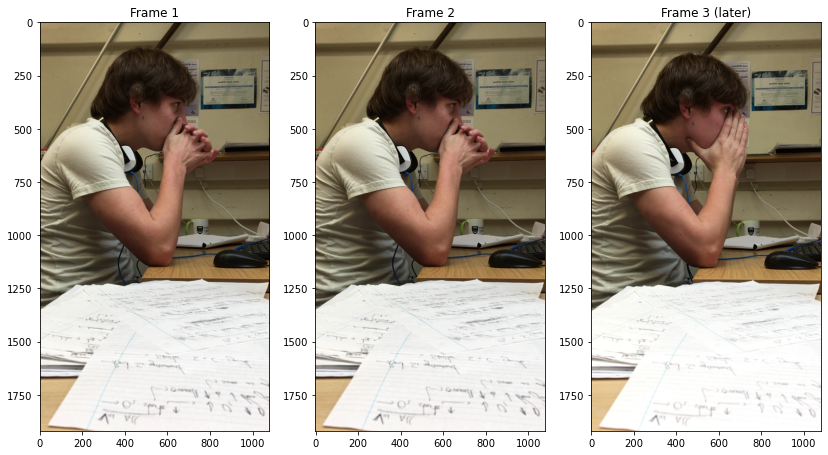

In [153]:
#Load three frames from the video
frame_1 = np.array(Image.open('image1.png'))
frame_2 = np.array(Image.open('image2.png'))
frame_3 = np.array(Image.open('image3.png'))

plt.subplot(1,3,1)
plt.imshow(frame_1);plt.title('Frame 1')
plt.subplot(1,3,2)
plt.imshow(frame_2);plt.title('Frame 2')
plt.subplot(1,3,3)
plt.imshow(frame_3);plt.title('Frame 3 (later)');plt.show()

The first two frames look almost identical, while more changes are visible between them and the third frame.

Let's see whether the computer can do a good job detecting this movement. Run the code below to calculate the motion between the first and second frames:

*Q10: Did the optical flow algorithm do a good job measuring movement between the video frames? What is the approximate scale of displacement between the frames (use an object of known size, e.g. the head to get an idea of the resolution)?*

Edit the code below to instead calcualte the displacement between the first and third video frames.

*Q11: Is the displacement larger or smaller between the first and third frames relative to the first and second ? Is this as expected?*

Still using the first and third image, try adjusting the window size (winsize) of the optical flow. The default here is a window size of 15 pixels.

*Q12: What is the effect of increasing the window size to 50 pixels? And what of decreasing it to 5 pixels? Which displacement map do you think is more useful?*

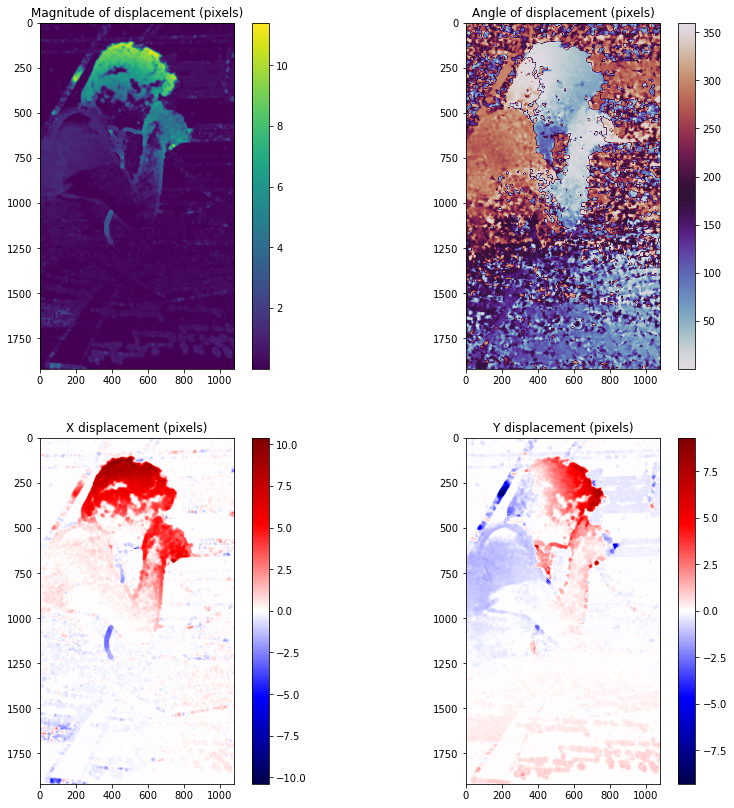

In [5]:
#Parameters (to edit)
image1 = frame_1[:,:,1]
image2 = frame_2[:,:,1]
levels = 3
winsize = 15
iterations = 3
poly_n = 5


#Parameters (no need to edit)
flow = None
pyr_scale = 0.5
poly_sigma = 1.2


#Calcualate displacements using Gunnar-Farneback's algorithm
mag,ang,u,v = GFopticalFlow(image1,
                            image2,
                            flow,
                            pyr_scale,
                            levels,
                            winsize,
                            iterations,
                            poly_n,
                            poly_sigma)

#Plot the data
fourPlot(mag,ang,u,v)


Now, try and compare motion between these frames using a different method: feature tracking. Run the code below.

*Q13: How does the displacement map from feature tracking compare to the one calcualted from optical flow? Which one has higher noise levels?*

Try changing two of the parameters in the code below: skip_ratio (how closely spaced the grid of displacement measurements is -- lower is denser) and reference window size (how large the group of pixels being compared is).

*Q14: What effect do these two parameters have on the smoothness or noise level of the output displacement maps?*

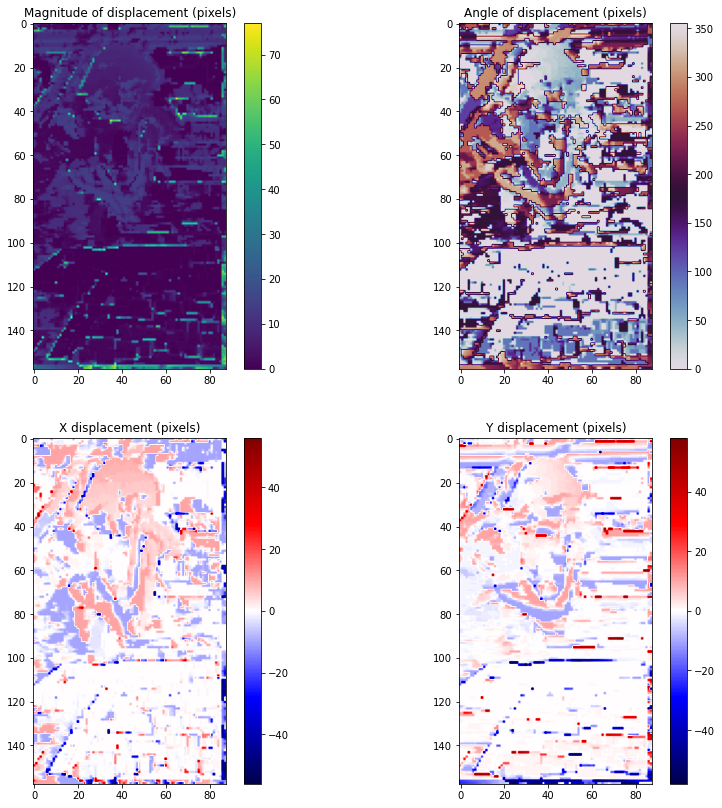

In [21]:
#Parameters:
image1 = frame_1[:,:,1]
image2 = frame_2[:,:,1]
skip_ratio = 0.25
reference_window_size =50
search_window_size = reference_window_size+20

#Run the feature tracking
mag,ang,u,v =FeatTrack(image1,
                       image2,
                       skip_ratio,
                       reference_window_size,
                       search_window_size)


#Plot the data
fourPlot(mag,ang,u,v)

**2) Measuring glacier flow: Perito Moreno Glacier, Patagonia**

The availability of multi temporal, stereoscopic and multi spectral imagery from wavelengths across the electromagnetic spectrum has greatly improved our ability to assess glaciological conditions and study changes in the cryosphere. Satellite remote sensing is particularly useful in the field of glaciology, due to the oft inaccessible and inhospitable study locations, as well as the ability of satellite imagery to permit year-round, real-time, and long-term studies.

Feature tracking is a method that allows the estimation of a displacement between pairs of satellite images that can be used, given knowledge of the time interval between an image pair, to calculate ice velocity. Individual features could be ice pinnacles, crevasses, boulders or a pattern of debris/ice, which can be identified on both images.

A window is chosen in the reference (first/master) image centred around a pixel (x,y). Following this, a window of the same size is extracted from the search (second/slave) image but translated by (u,v) pixels within a specified search window Ωs, illustrated in Figure 1. This is then compared to Ωr using a function of similarity.

This operation is repeated for different values of (u,v), and the position of maximum similarity, interpolated to a fraction of a pixel, is a measure of displacement. This is then used to calculate ice velocity – i.e. with knowledge of the time interval between an image pair, velocity=displacement/time.

![title](images/ftrack_sketch.png)

To explore this, we are going to use two Sentinel-2 satellite images of Perito-Moreno glacier in Patagonia. Perito-Moreno is a large (~20 km long, 3 km wide) lakewater glacier, which is well know for periodically advancing and damming the lake it calves into.

Perito Moreno is a good spot to try out feature tracking - it is large, fast moving, and its surface is heavily crevasses (many 'features' to track). To give you an idea of its scale, here are a couple of photos we took in January 2020 of the glacier front and surface while installing monitoring equipment.

![title](images/pmoreno.jpg)
![title](images/pmoreno_stake.jpg)

In the cell below, we load and plot two Sentinel-2 satellite images of Perito Moreno from 01 Jan 2020 and 10 Feb 2020. The lower two subpanels are a zoomed in version of the upper image.

*Q15: Can you see any differences between these images (e.g. clouds, shadows, change in show cover) which may affect out feature tracking?*

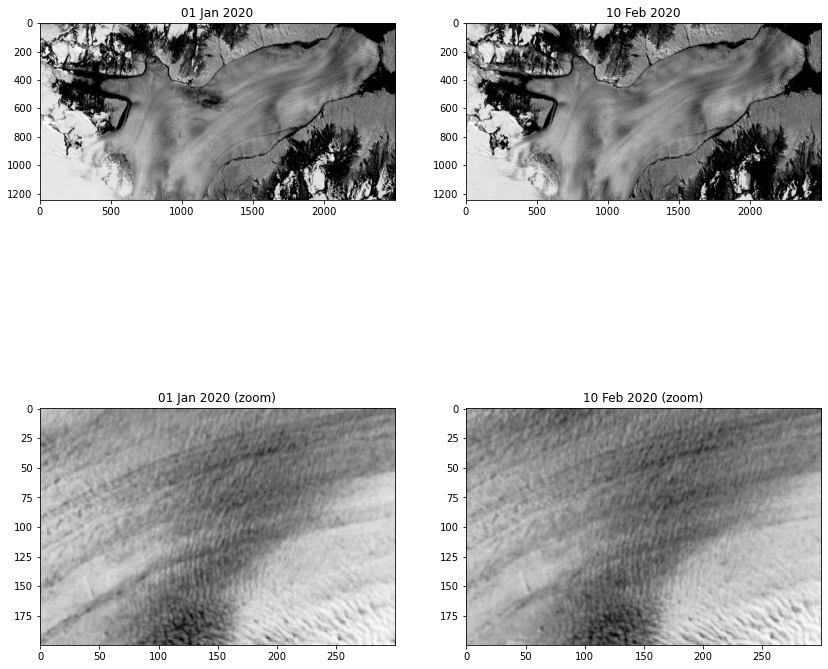

In [32]:
#Load images
image1,image2 = loadProductOptical('20200101.tif', '20200210.tif')

#Plot
plt.subplot(2,2,1)
plt.imshow(image1,cmap='Greys_r');plt.title('01 Jan 2020')
plt.subplot(2,2,2)
plt.imshow(image2,cmap='Greys_r');plt.title('10 Feb 2020')
plt.subplot(2,2,3)
plt.imshow(image1[400:600,1500:1800],cmap='Greys_r');plt.title('01 Jan 2020 (zoom)')
plt.subplot(2,2,4)
plt.imshow(image2[400:600,1500:1800],cmap='Greys_r');plt.title('10 Feb 2020 (zoom)');plt.show()

Now, let's run the feature tracking algorithm on these images and see how fast the glacier is moving.

*Q16: How well did the feature tracking work? Approximatively how many pixels did the centre of Perito Moreno move between these dates?*

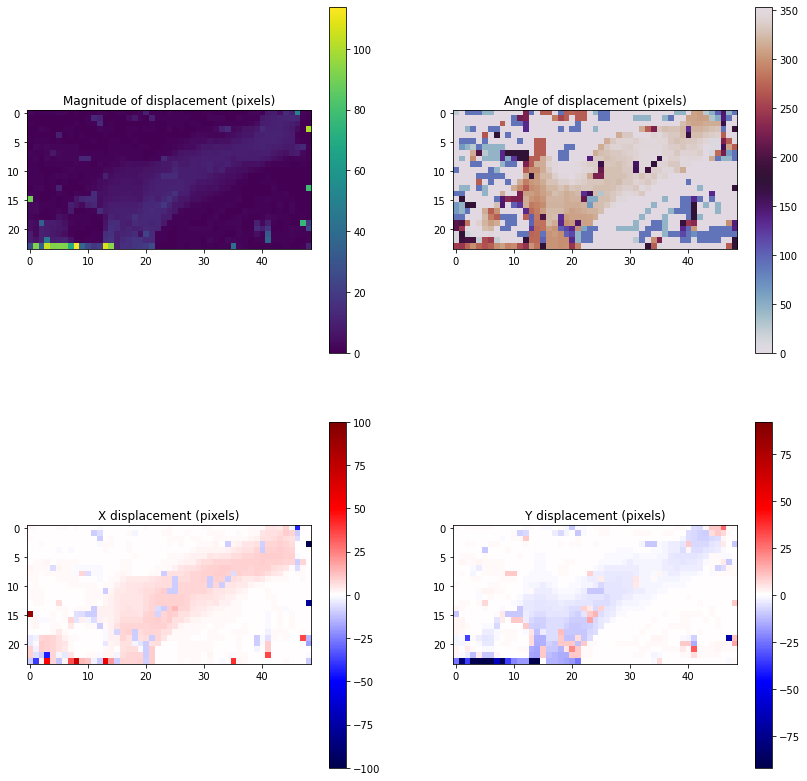

In [19]:
#Parameters:
image1 = image1
image2 = image2
skip_ratio = 0.5
reference_window_size =100
search_window_size = reference_window_size+20

#Run the feature tracking
mag,ang,u,v =FeatTrack(image1,
                       image2,
                       skip_ratio,
                       reference_window_size,
                       search_window_size)
# # #Threshold
# cutoff = 50
# # u = u.astype(float)
# # v = v.astype(float)
# # u[mag>cutoff]=np.nan
# # v[mag>cutoff]=np.nan
# ang[mag>cutoff]=np.nan
# mag[mag>cutoff]=np.nan

#Plot the data
fourPlot(mag,ang,u,v)

That worked, but the velocity map is still quite noisy and difficult to interpret. In order to improve the quality of our velocity map, we can do three things:

1. Preprocess the images. This involves applying a filter to the images to reduce their noise levels, or better reveal surface patterns.

2. Adjust the feature tracking parameters--for instance finding the optimal window size for a given glacier.

3. Post-process the resulting displacement maps to remove incorrect values (noise).

There are three code cells below, dealing with the three points listed above. The first pre-processes the satellite images, the second runs the feature tracking, and the third post-processes the imagery. Test out different combinations of code, and answer the questions below.


*Q17: Test different pre-processing options in the first cell, and examine the resulting images. Can you see why these might result in better feature-tracking results?*

*Q18: Now, run the second cell after having pre-processed the images differently (try once with 'none'=no preprocesing and once with 'sobel' = preprocessed with the Sobel filter). Does pre-processing lead to a smoother, less noisy velocity map?*

*Q19: Now, change the pre-processing back to 'none' and run the first two cells again. Test the different options in the third (pos-processing) cell. Does thresholding succesfully remove outliers? What about median filtering? If you turn on the interpolate_missing_values_flag, how does your final velocity map look?*

*Q20: What combination of pre- and post-processing leads to the best final velocity map? Run this, and describe the difference relative to the velocity map you calcualted above.*

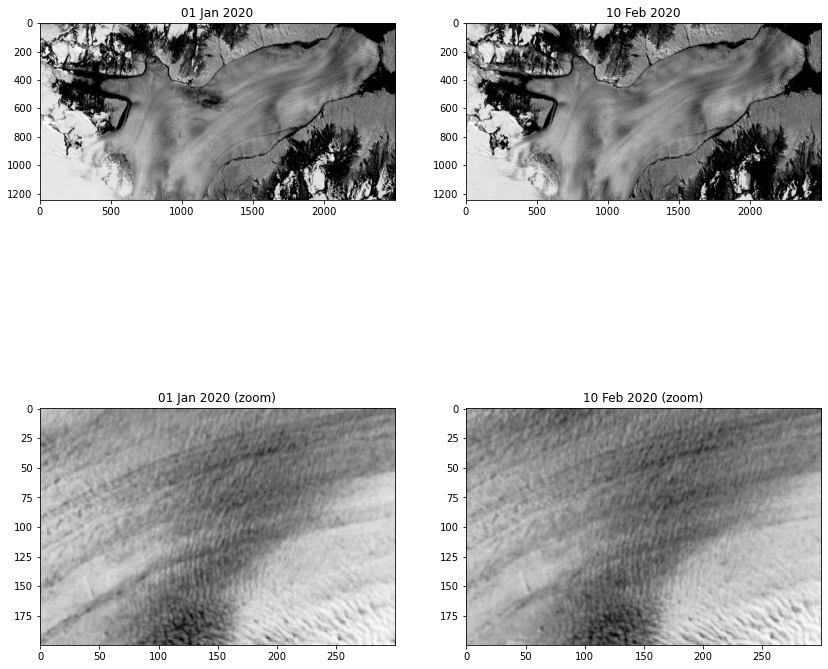

In [119]:
### 1: PRE-PROCESSING

#Edit here: can be 'none', 'highpass', 'laplacian', 'wallis', 'sobel'
preprocessing_type = 'none'

#Load images
image1,image2 = loadProductOptical('20200101.tif', '20200210.tif')

image1,image2 = autoRIFT_preprocess(image1,image2,preprocessing_type)

#Plot
plt.subplot(2,2,1)
plt.imshow(image1,cmap='Greys_r');plt.title('01 Jan 2020')
plt.subplot(2,2,2)
plt.imshow(image2,cmap='Greys_r');plt.title('10 Feb 2020')
plt.subplot(2,2,3)
plt.imshow(image1[400:600,1500:1800],cmap='Greys_r');plt.title('01 Jan 2020 (zoom)')
plt.subplot(2,2,4)
plt.imshow(image2[400:600,1500:1800],cmap='Greys_r');plt.title('10 Feb 2020 (zoom)');plt.show()

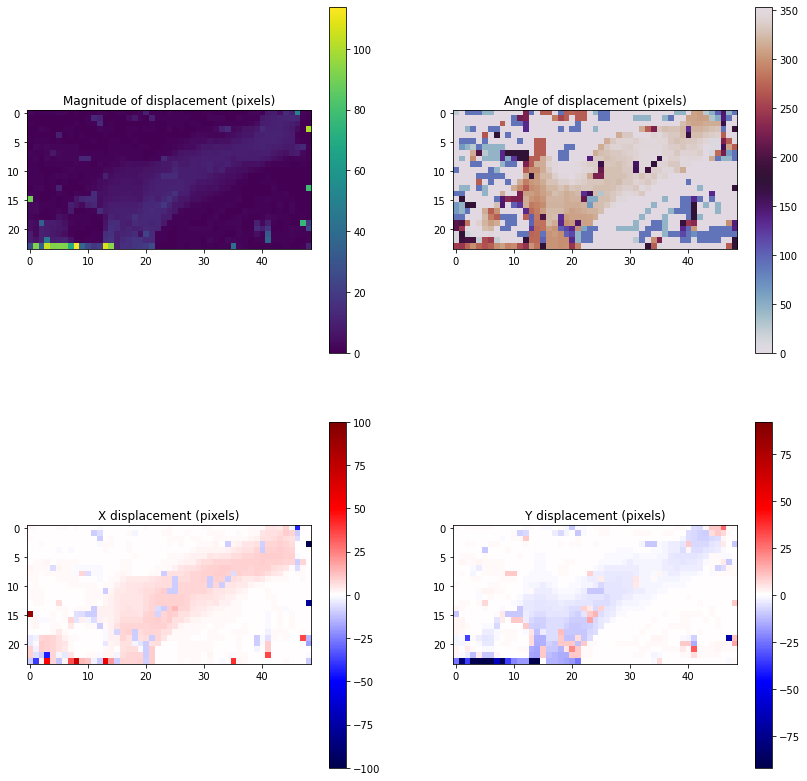

In [101]:
### 2: FEATURE TRACKING
skip_ratio = 0.5
reference_window_size =100
search_window_size = reference_window_size+20

#Run the feature tracking
mag1,ang1,u1,v1 =FeatTrack(image1,
                       image2,
                       skip_ratio,
                       reference_window_size,
                       search_window_size)

#Plot the data
fourPlot(mag1,ang1,u1,v1)

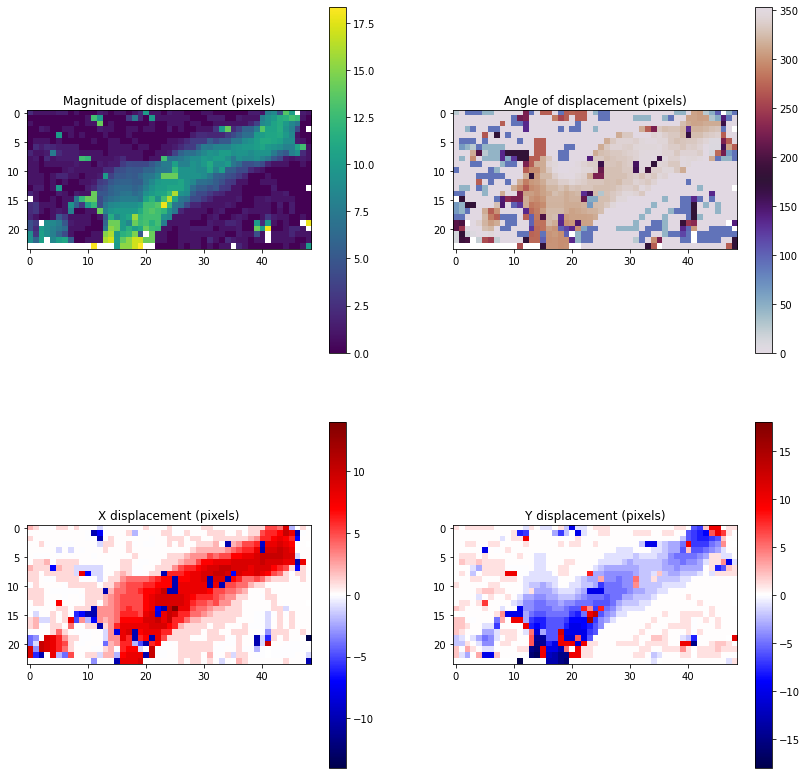

In [103]:
### 3: POST-PROCESSING
# Set these to 'on' or 'off'
velocity_filter ='on'
velocity_filter_threshold_cutoff = 20 #Lower = more values removed

local_median_filter ='off'
local_median_filter_threshold = 0.5; #Lower = more values removed

interpolate_missing_values_flag ='of'

u = u1;v=v1;ang=ang1;mag=mag1
u[u==0]=np.nan;v[v==0]=np.nan
# Velocity threshold filter
if velocity_filter =='on':
    cutoff = velocity_filter_threshold_cutoff
    ang[mag>cutoff]=np.nan
    mag[mag>cutoff]=np.nan
    u,v = cv2.polarToCart(mag,ang)

# X and Y component local median filter
if local_median_filter =='on':
    ua = np.abs(u);    va = np.abs(v)
    uf = signal.medfilt2d(u);    vf = signal.medfilt2d(v)
    u[np.abs(uf-u)/ua >1]=np.nan
    v[np.abs(vf-v)/va >1]=np.nan
    mag,ang= cv2.cartToPolar(u,v)
    
    #Infill any missing (NaN) values
if interpolate_missing_values_flag =='on':
    u = interp_missing_values(u,method='linear')
    v = interp_missing_values(v,method='linear')
    mag,ang=cv2.cartToPolar(u,v)


#Plot the data
fourPlot(mag,ang,u,v)

Finally, edit the code above to convert these displacements (in pixels) to a more meaningful value--we usually use metres per year in glaciology.

For this you will need to multiply the displacements by the image resolution (can you remember what Sentinel-2's resolution is? Google will tell you if not!) and the timing between images (how many days are between 01 Jan 2020 and 10 Feb 2020). Discuss this among yourselves if you are not sure where to add this to the code.



We can also try and calculate the velocity of Perito Moreno using optical flow. The conditions of the images are close to ideal (clean glacier surface, few shadows) so this should work as well. Run the code below.

*Q21: A prominent gap is visible in the velocity map in the upper centre of the glacier. By looking at the original images, can you guess why this is?*

*Q22: Try adding pre- and post-processing to the code below based on what we did with the feature tracking above. Can you improve this velocity map as well?*

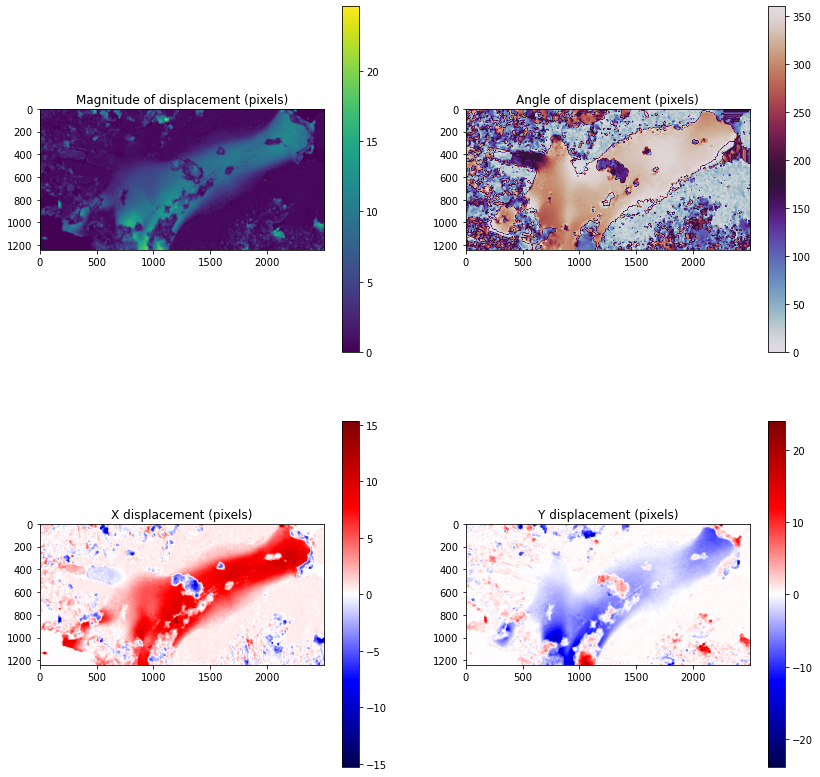

In [120]:
#Load images
image1,image2 = loadProductOptical('20200101.tif', '20200210.tif')


#Parameters (to edit)
levels = 3
winsize = 15
iterations = 3
poly_n = 5


#Parameters (no need to edit)
flow = None
pyr_scale = 0.5
poly_sigma = 1.2


#Calcualate displacements using Gunnar-Farneback's algorithm
mag,ang,u,v = GFopticalFlow(image1,
                            image2,
                            flow,
                            pyr_scale,
                            levels,
                            winsize,
                            iterations,
                            poly_n,
                            poly_sigma)


#Plot the data
fourPlot(mag,ang,u,v)

**3) Calculating earthquake moment magnitude from satellite imagery**

![title](images/shakemap.jpg)

A very large earthquake occurred in the South Island of New Zealand in November 2016. Luckily, this occurred in a sparsely populated part of the country, and caused much less damage than the 2011 Christchurch earthquake in the same region. Nevertheless, the 2016 earthquake killed two people and caused widespread destruction in the area. The photos below show just a couple of examples.

![title](images/earthquake.png)

A key measure used in assessing the size of earthquakes is the Moment Magnitude--which essentially provides a scale of the energy released (and amount of shaking caused) by a given earthquake.

It is calculated according to the following formula:
![title](images/equation_1.png)

With M_W the Moment Magnitude and M_0 the seismic moment.

The seismic moment is given by

M_0 = [amount of slip on fault] * [area of slip on fault] * [shear modulus of the rocks]

The shear modulus is generally known, or can be estimated from the local geology.

*Your objective in this question is to calculate the seismic moment of the Kaikura earthquake using only satellite imagery--you already know how to!*

*You will need to edit the code below in order to:*

*1. Calculate the length of the fault rupture* 

*2. Calculate the displacement at the fault plane*

I have coded up some parts of it in order to help you get started. You should probably get in groups (if you are not already) to discuss this problem.

Your output should be a single number: the Moment Magnitude. A large earthquake like this is expected to be in the range 6-9, if your value is not on that order, you have probably missed something (feel free to ask for help as well!).

Other information you may need: 
* These satellite images are from Landsat 8, and have a resolution of 15 m per pixel
* The local rock shear modulus is around 20 GPa (2 x 10^10 Pascals).
* The fault rupture depth was around 30 km (remember, fault area = length * depth).
* We assume the surface displacement is representative of the entire fault.

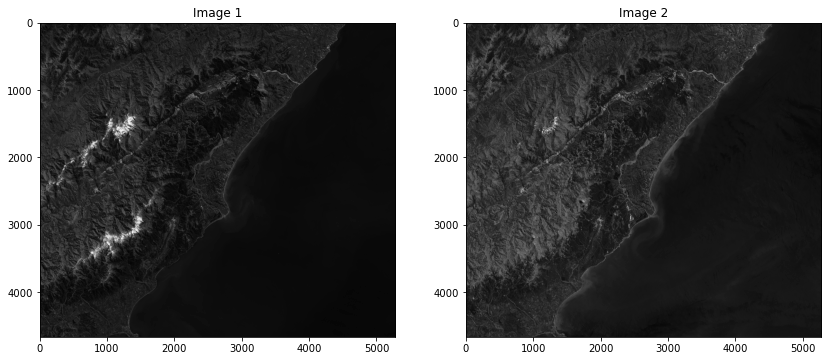

In [133]:
# Enter your code here!

#Load images
image1,image2 = loadProductOptical('LC08_L1TP_073089_20161012_20170319_01_T1_B8crop.TIF',
                           'LC08_L1TP_073089_20161215_20170316_01_T1_B8crop.TIF')

#Plot images
plt.subplot(1,2,1)
plt.imshow(image1**0.1,cmap='Greys_r');plt.title('Image 1')
plt.subplot(1,2,2)
plt.imshow(image2**0.1,cmap='Greys_r');plt.title('Image 2');plt.show()

#Run feature tracking (but no pre- or post-processing here! You will need to add that yourself if you think it would help.)
mag,ang,u,v = autoRIFT_launch(I1,I2)

In [ ]:
# Second code cell-- this one just has the formula for seismic moment magnitude

shear_modulus = 2e10 #20 GPa

slip_amount = #You need to calculate this!

fault_rupture_depth = 30000 #30 km

fault_rupture_length = #You need to calculate this!

rupture_area = fault_rupture_length*fault_rupture_depth

moment_magnitude = (np.log10(rupture_area*slip_amount*shear_modulus)-9.05)/1.5

print('Your moment magnitude is ' + str(moment_magnitude))

Excellent! You have made it to the end of the practical. I hope you have learnt something about the value of feature tracking, and picked up a little python along the way. 